<a href="https://colab.research.google.com/github/hidemyas/TensorFlow-Brain-Tumor-Siniflandirma/blob/main/TensorFlow_ile_Brain_Tumor_MRI_S%C4%B1n%C4%B1fland%C4%B1rmas%C4%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow  ile Brain Tumor MRI Sınıflandırması


## İçindekiler
1. Gerekli Kütüphanelerin Yüklenmesi
2. Veri Setinin Yüklenmesi ve İncelenmesi
3. Veri Görselleştirme
4. Veri Önişleme ve Data Augmentation
5. Modelin Kurulması (VGG16 Tabanlı CNN)
6. Modelin Eğitilmesi
7. Modelin Değerlendirilmesi (Grafikler, Confusion Matrix, Classification Report)
8. Grad-CAM Görselleştirme
9. Hiperparametre Denemeleri


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
import os
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import SGD

### GPU için optimize edelim

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  print("GPU desteği etkin! Bulunan GPU:", gpus)
else:
  print("GPU bulunamadı. Lütfen kurulumları kontrol edin.")

GPU desteği etkin! Bulunan GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 2. Veri Setinin Yüklenmesi ve İncelenmesi

In [3]:
import kagglehub

# Kaggle Brain Tumor MRI dataset
# Dataset link: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset

data_dir = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

img_height, img_width = 224, 224
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_dir, "Training"),
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_dir, "Testing"),
    image_size=(img_height, img_width),
    batch_size=batch_size
)

class_names = train_ds.class_names
print("Sınıflar:", class_names)


Using Colab cache for faster access to the 'brain-tumor-mri-dataset' dataset.
Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.
Sınıflar: ['glioma', 'meningioma', 'notumor', 'pituitary']


## 3. Veri Görselleştirme

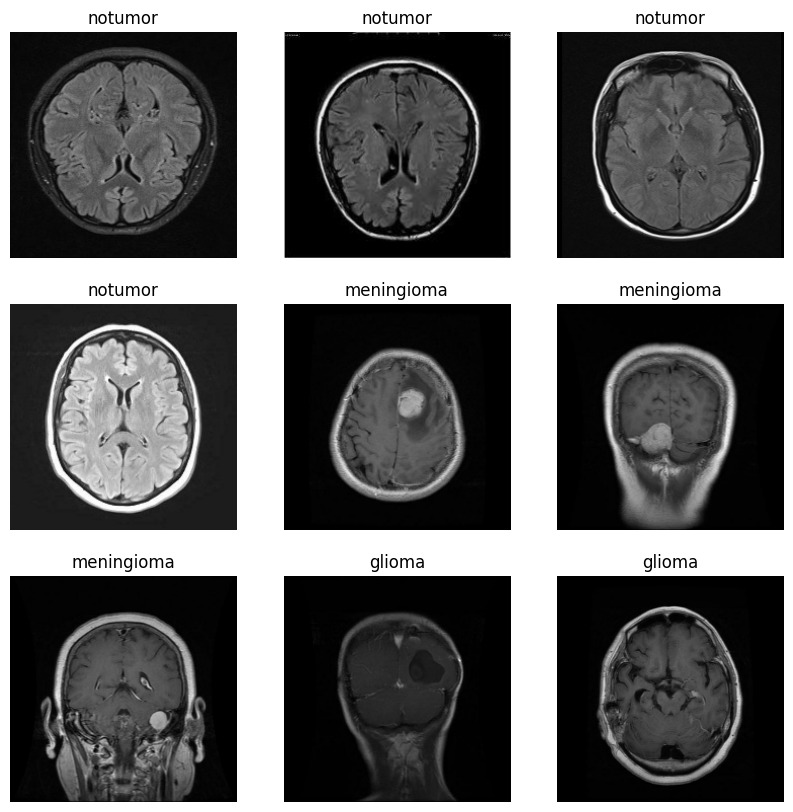

In [4]:

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


## 4. Veri Önişleme ve Data Augmentation

In [5]:

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])


## 5. Modelin Kurulması (VGG16 Tabanlı CNN)

In [6]:

num_classes = len(class_names)

# VGG16 modelini yüklüyoruz. include_top=False ile son sınıflandırma katmanlarını hariç tutuyoruz.
base_model = VGG16(input_shape=(img_height, img_width, 3),
                   include_top=False,
                   weights='imagenet')

# Makalede belirtildiği gibi, ilk 4 bloğu donduruyoruz.
for layer in base_model.layers[:15]:  # İlk 15 katman ilk 4 bloğu içerir
    layer.trainable = False

# Kendi sınıflandırma katmanlarımızı ekliyoruz.
model = models.Sequential([
    layers.Input(shape=(img_height, img_width, 3)),
    layers.Rescaling(1./255),
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])


model.compile(optimizer=SGD(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,868 (56.38 MB)

 Trainable params: 7,145,604 (27.26 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

## 6. Modelin Eğitilmesi

In [7]:
epochs = 30
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 64s 209ms/step - accuracy: 0.3257 - loss: 1.4257 - val_accuracy: 0.6331 - val_loss: 1.0568 - learning_rate: 0.0010
Epoch 2/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 49s 170ms/step - accuracy: 0.6127 - loss: 0.9915 - val_accuracy: 0.6796 - val_loss: 0.8613 - learning_rate: 0.0010
Epoch 3/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 31s 172ms/step - accuracy: 0.6914 - loss: 0.8160 - val_accuracy: 0.7292 - val_loss: 0.7573 - learning_rate: 0.0010
Epoch 4/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 41s 174ms/step - accuracy: 0.7331 - loss: 0.7155 - val_accuracy: 0.7323 - val_loss: 0.7302 - learning_rate: 0.0010
Epoch 5/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 31s 175ms/step - accuracy: 0.7591 - loss: 0.6585 - val_accuracy: 0.7429 - val_loss: 0.7000 - learning_rate: 0.0010
Epoch 6/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 41s 176ms/step - accuracy: 0.7829 - loss: 0.5957 - val_accuracy: 0.7567 - val_loss: 0.6328 - learning_rate: 0.0010
Epoch 7/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 32s 177ms/step - accuracy: 0.8

## 7. Modelin Değerlendirilmesi

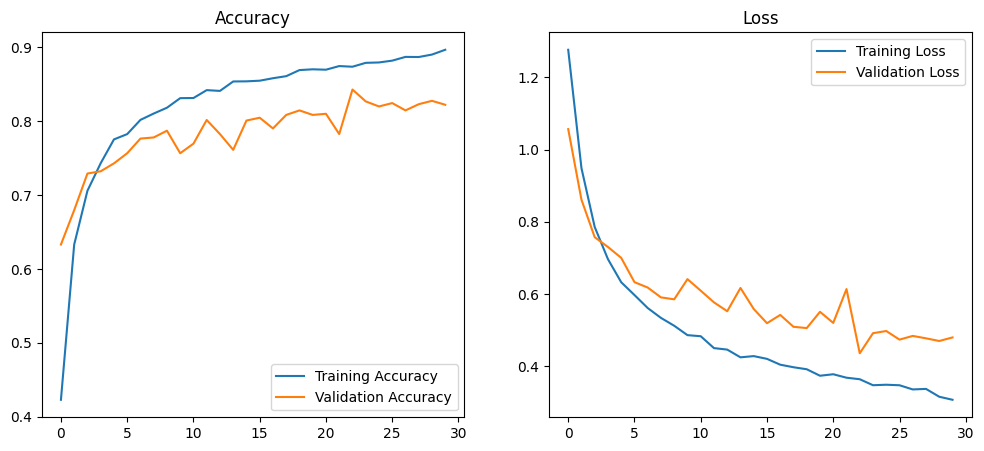

In [8]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

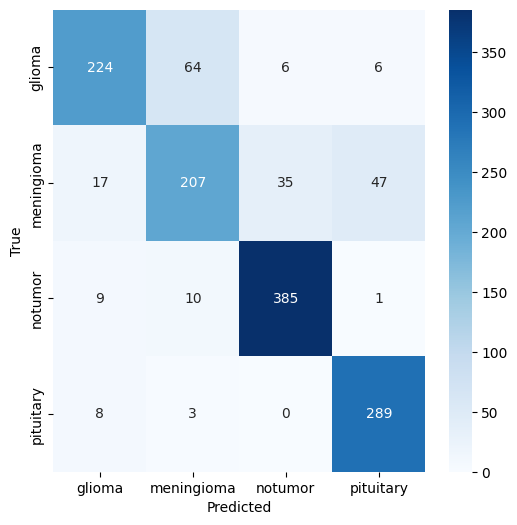

              precision    recall  f1-score   support

      glioma       0.87      0.75      0.80       300
  meningioma       0.73      0.68      0.70       306
     notumor       0.90      0.95      0.93       405
   pituitary       0.84      0.96      0.90       300

    accuracy                           0.84      1311
   macro avg       0.84      0.83      0.83      1311
weighted avg       0.84      0.84      0.84      1311



In [9]:
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))
